<a href="https://colab.research.google.com/github/aliakbarbadri/mountain-car-v0/blob/master/dueling_double_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the packages and Show the video

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet

In [ ]:
import matplotlib.animation
from IPython.display import HTML
from IPython.display import display as ipy_disp
import tensorflow as tf
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gym
import random

In [ ]:
# %matplotlib inline

def get_screen():
  global display
  try:
    display.stop()
  except:
    pass
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()

get_screen()

In [ ]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
HW_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [ ]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Setup the Env

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
env.seed(42)
obs = env.reset()
obs
# obs = array([position, velocity])
# position = [-1.2 , 0.6]
# velocity = [-0.07,	0.07]

array([-0.52517132,  0.        ])

In [ ]:
env.action_space
# 0	push left
# 1	no push
# 2	push right

Discrete(3)

In [ ]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

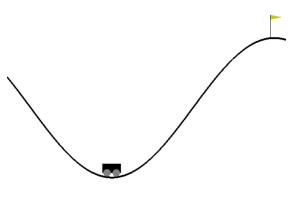

In [ ]:
plot_environment(env)
plt.show()

In [ ]:
action = 0
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.52615953, -0.00098821]), -1.0, False, {})

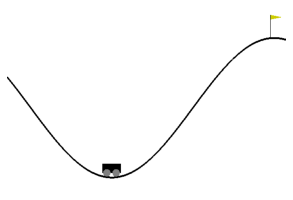

In [ ]:
plot_environment(env)
plt.show()

# Random Actions

In [ ]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break

In [ ]:
plot_animation(frames)

# Dueling Double DQN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
input_shape = env.observation_space.shape
n_outputs = env.action_space.n

K = tf.keras.backend
input_states = tf.keras.layers.Input(shape=[input_shape])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = tf.keras.optimizers.Adam(lr=1e-2)
loss_fn = tf.keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [ ]:
env.close()
